In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Pinecone
from langchain.chains import RetrievalQA
from langchain_openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
from dotenv import load_dotenv
import os

C:\Users\jose.farfan\AppData\Local\anaconda3\envs\tfm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()
openai_api_key =  os.getenv("OPENAI_API_KEY")
pinecone_api_key = os.environ["PINECONE_API_KEY"]
index_name='tfm-rag-chunk-2000'
namespace = "incidents-2000"

embeddings = OpenAIEmbeddings()
vstore = Pinecone.from_existing_index(
    index_name=index_name,
    namespace=namespace,
    embedding=embeddings)
llm = ChatOpenAI(model="gpt-4o",temperature=0)

In [4]:
df = pd.read_csv('testDataset.csv')
questions=df.iloc[:, 0].tolist()
ground_truths =df.iloc[:, 1].tolist() 

In [5]:
prompt_template = PromptTemplate(
    input_variables=["incident"],
    template="""
    Eres un experto en sistemas de información.
    Genera una solución al incidente descrito a continuación basado en tu conocimiento previo representado en el contexto obtenido. Si dentro del contexto compartido no se presentan incidentes similares responde que no conoces como resolver el incidente
    Descripción del incidente: {incident}
    
    """
    )

In [6]:
def retrieve(user_question):
    docs = vstore.similarity_search(user_question)
    return docs
def generate(docs, user_question):
    
    prompt = prompt_template.format(incident=user_question)
    chain = load_qa_chain(llm, chain_type="stuff")
    response = chain.invoke({"input_documents":docs, "question":prompt})
    return response['output_text']
    #chain = load_qa_chain(llm, chain_type="stuff")
    #response = chain.run(input_documents=docs, question=prompt)
    #return response

In [7]:
answers = []
contexts = []
formatted_questions = [prompt_template.format(incident=q) for q in questions]
# Inference
for query in formatted_questions:
    docs=retrieve(query)
    answers.append(generate(docs, query))
    contexts.append([doc.page_content for doc in docs])



C:\Users\jose.farfan\AppData\Local\Temp\ipykernel_34552\1987522355.py:7: LangChainDeprecationWarning: This class is deprecated. See the following migration guides for replacements based on `chain_type`:
stuff: https://python.langchain.com/v0.2/docs/versions/migrating_chains/stuff_docs_chain
map_reduce: https://python.langchain.com/v0.2/docs/versions/migrating_chains/map_reduce_chain
refine: https://python.langchain.com/v0.2/docs/versions/migrating_chains/refine_chain
map_rerank: https://python.langchain.com/v0.2/docs/versions/migrating_chains/map_rerank_docs_chain

See also guides on retrieval and question-answering here: https://python.langchain.com/v0.2/docs/how_to/#qa-with-rag
  chain = load_qa_chain(llm, chain_type="stuff")


In [8]:
# To dict
data = {
    "question": formatted_questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truths
}

In [9]:
dataset = Dataset.from_dict(data)

In [10]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

C:\Users\jose.farfan\AppData\Local\anaconda3\envs\tfm\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_name" in _VertexAIBase has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
C:\Users\jose.farfan\AppData\Local\anaconda3\envs\tfm\Lib\site-packages\pydantic\_internal\_fields.py:132: UserWarning: Field "model_name" in _VertexAICommon has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
C:\Users\jose.farfan\AppData\Local\anaconda3\envs\tfm\Lib\site-packages\ragas\metrics\__init__.py:4: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly

In [11]:
result = evaluate(
    dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)


Evaluating: 100%|██████████| 68/68 [00:46<00:00,  1.46it/s]


In [12]:
print(result)

{'context_precision': 0.9804, 'context_recall': 0.6324, 'faithfulness': 0.4969, 'answer_relevancy': 0.7594}


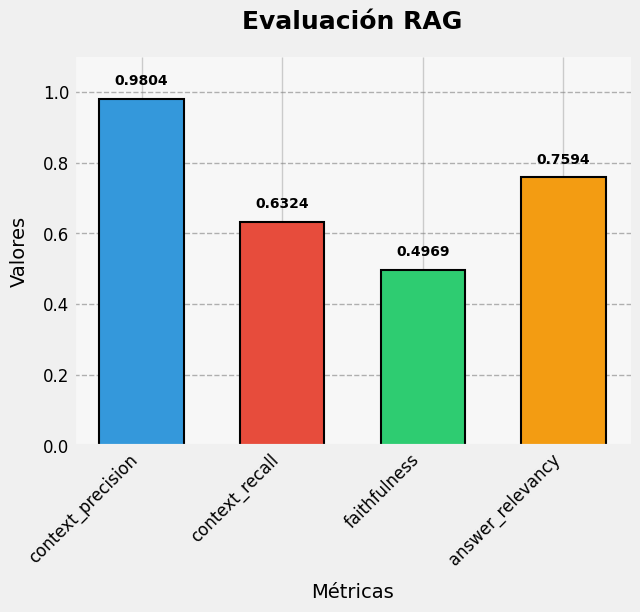

In [13]:
# Extraer las claves y valores para el gráfico
labels = list(result.keys())
values = list(result.values())

# Establecer el estilo del gráfico
plt.style.use('fivethirtyeight')

# Crear el gráfico de barras con colores personalizados y grosor de las barras
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars = plt.bar(labels, values, color=colors, edgecolor='black', linewidth=1.5, width=0.6)

# Añadir etiquetas de valores sobre las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.03, f'{yval:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

# Añadir títulos y etiquetas con fuente mejorada
plt.title('Evaluación RAG', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Métricas', fontsize=14, labelpad=10)
plt.ylabel('Valores', fontsize=14, labelpad=10)

# Mejorar las etiquetas de los ejes
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Añadir un fondo sutil al gráfico
plt.gca().set_facecolor('#f7f7f7')

# Añadir cuadrícula al eje Y con un estilo más suave
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')

# Aumentar los márgenes para mejorar la legibilidad
plt.ylim(0, 1.1)

# Eliminar las líneas superior y derecha del marco
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Mostrar el gráfico
plt.show()

In [14]:
df = result.to_pandas()

In [1]:
styled_df = df.style.background_gradient(
    cmap='RdBu',  # Mapa de color que va de rojo a verde
    axis=None,  # Aplica el gradiente en todas las columnas numéricas
    vmin=0,  # Valor mínimo para el gradiente
    vmax=1   # Valor máximo para el gradiente
)

# Mostrar la tabla estilizada
styled_df

NameError: name 'df' is not defined

In [ ]:
import pandas as pd

# Asumiendo que ya tienes el DataFrame cargado en la variable df
df_tabla=df[['question', 'answer', 'ground_truth','context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']]

# Aplicar el gradiente de color usando Styler.background_gradient
styled_df = df_tabla.style.background_gradient(
    cmap='RdBu',  # Mapa de color que va de rojo a verde
    axis=None,  # Aplica el gradiente en todas las columnas numéricas
    vmin=0,  # Valor mínimo para el gradiente
    vmax=1   # Valor máximo para el gradiente
)

# Mostrar la tabla estilizada
styled_df

In [17]:
df.to_csv('resultados-tfm-rag-chunk-2000.csv', index=False)